# Versioning info

In [1]:
import qiskit.tools.jupyter

%qiskit_version_table

In [2]:
folder_name = "results/"

# Utility function

Used to display progress in numerical experiments.

In [3]:
import time, sys
from IPython.display import clear_output

def update_progress(progress, text = "Progress", clear=False):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))
    
    if clear:
        clear_output(wait = True)
        
    text += ": [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    
    print(text)

# Quantum Amplitude Estimation workflow

First create a dummy circuit that will be used to compare different QAE algorithms. The circuit allows us to estimate a given probability (`p` below).

In [4]:
import numpy as np
from qiskit.circuit import QuantumCircuit


class BernoulliA(QuantumCircuit):
    """A circuit representing the Bernoulli A operator."""

    def __init__(self, probability):
        super().__init__(1)  # circuit on 1 qubit

        theta_p = 2 * np.arcsin(np.sqrt(probability))
        self.ry(theta_p, 0)


class BernoulliQ(QuantumCircuit):
    """A circuit representing the Bernoulli Q operator."""

    def __init__(self, probability):
        super().__init__(1)  # circuit on 1 qubit

        self._theta_p = 2 * np.arcsin(np.sqrt(probability))
        self.ry(2 * self._theta_p, 0)

    def power(self, k):
        # implement the efficient power of Q
        q_k = QuantumCircuit(1)
        q_k.ry(2 * k * self._theta_p, 0)
        return q_k

We first define the estimation problem which will contain the $\mathcal{A}$ and $\mathcal{Q}$ operators as well as how to identify the $|\Psi_1\rangle$ state, which in this simple example is just $|1\rangle$.

In [5]:
from qiskit_algorithms import EstimationProblem

def create_estimation_problem(p):
    return EstimationProblem(
        state_preparation=BernoulliA(p),  # A operator
        grover_operator=BernoulliQ(p),  # Q operator
        objective_qubits=[0],  # the "good" state Psi1 is identified as measuring |1> in qubit 0
    )

To execute circuits we'll use `Sampler`.

In [6]:
from qiskit.primitives import Sampler

Now the main estimation routines.

In [7]:
import statistics as st
import os.path
import pandas as pd

def run_estimation (ae, problem, filename, max_number_of_reps, verbose = True):
    
    df = pd.DataFrame()
    if os.path.exists (filename):
        df = pd.read_csv(filename,index_col=0)

    reps_already_done = len(df.index)
    if max_number_of_reps <= reps_already_done:
        df = df.head(max_number_of_reps)
    
    else:
        estimate = []
        num_shots = []
        
        for rep in range(reps_already_done, max_number_of_reps):
            if verbose:
                #update_progress(rep/max_number_of_reps, filename)
                print (filename + ":", rep, "/", max_number_of_reps)
            ae_result = ae.estimate(problem)
            estimate.append(ae_result.estimation)
            num_shots.append(ae_result.num_oracle_queries)
    
            new_df = pd.DataFrame(zip(estimate,num_shots), columns=['estimate','shots'])
            df = pd.DataFrame(pd.concat([df, new_df], ignore_index=True))
            df.to_csv(filename)

        #if verbose:
        #    update_progress(1, filename)

    return df.describe()

In [8]:
def run_estimation_round (p, epsilon_target = 0.001, alpha = 0.05, max_number_of_reps = 1, folder_name = "", methods = {}, submethods = {}, verbose = True ):
    
    problem = create_estimation_problem(p)
    
    data = {}
    if verbose:
        print ("=================================")
        print (f"p = {p}, epsilon = {epsilon_target}, alpha = {alpha}")

    # IQAE method
    if "IQAE" in methods:
        data["IQAE"] = {}
        for confint in submethods["IQAE"]:
            iae = IterativeAmplitudeEstimation(
                epsilon_target=epsilon_target,  # target accuracy
                alpha=alpha,  # width of the confidence interval
                confint_method = confint,
                sampler=Sampler(options={'shots':500}),
            )
            filename = folder_name + "IQAE_"+confint+"_p="+str(p)+"_eps="+str(epsilon_target)+"_alpha="+str(alpha)+".csv"
            output = run_estimation (iae, problem, filename, max_number_of_reps, verbose)
            data["IQAE"][confint] = output

    # mod_IQAE method
    if "MIQAE" in methods:
        data["MIQAE"] = {}
        for confint in submethods["MIQAE"]:
            miae = ModifiedIterativeAmplitudeEstimation(
                epsilon_target = epsilon_target,  # target accuracy
                alpha = alpha,  # width of the confidence interval
                shots = 1,
                confint_method = confint,
                sampler = Sampler()
            )
            filename = folder_name + "MIQAE_"+confint+"_p="+str(p)+"_eps="+str(epsilon_target)+"_alpha="+str(alpha)+".csv"
            output = run_estimation (miae, problem, filename, max_number_of_reps, verbose)
            data["MIQAE"][confint] = output

    # Our method
    for method in {"standard","accelerated"}:
        if "AQAE_"+method in methods:
            data["AQAE_"+method] = {}
            for confint in submethods["AQAE_"+method]:
                aqae = OurAmplitudeEstimation(
                    epsilon_target=epsilon_target,  # target accuracy
                    alpha=alpha,  # width of the confidence interval
                    method=method,
                    confint_method = confint,
                    sampler=Sampler(),
                    debug=False        
                )
                filename = folder_name + "AQAE_"+method+"_" + confint + "_p="+str(p)+"_eps="+str(epsilon_target)+"_alpha="+str(alpha)+".csv"
                output = run_estimation (aqae, problem, filename, max_number_of_reps, verbose)
                data["AQAE_"+method][confint] = output
    
    if verbose:
        print ("=================================")
    
    return data

# Comparing our method with others

In [10]:
# for IQAE method
from qiskit_algorithms import IterativeAmplitudeEstimation

# for modified IQAE method
# https://github.com/shifubear/Modified-IQAE/
# updated for compatibility with current version of Qiskit
from mod_iae import ModifiedIterativeAmplitudeEstimation

# for our method
from aqae import OurAmplitudeEstimation

# for graphs
import matplotlib.pyplot as plt

In [11]:
submethods = {}
submethods["IQAE"] = ["chernoff","beta"]
submethods["MIQAE"] = ["chernoff","beta"]
submethods["AQAE_standard"] = ["hoeffding","clopper_pearson", "score"]
submethods["AQAE_accelerated"] = ["hoeffding","clopper_pearson", "score"]

In [12]:
p = 0.5
alpha = 0.05
max_number_of_reps = 2000

# methods
methods = ["AQAE_standard", "AQAE_accelerated", "MIQAE", "IQAE"]

epsilon = np.array([0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001, 0.0000001, 0.00000001, 0.000000001])

# data for plotting
data = []

for epsilon_target in epsilon:
    new_data = run_estimation_round (p, epsilon_target=epsilon_target, alpha=alpha, max_number_of_reps = max_number_of_reps, folder_name=folder_name, methods=methods, submethods=submethods,verbose=True)
    data.append(new_data)

for epsilon_target in epsilon:
    new_data = run_estimation_round (p, epsilon_target=epsilon_target, alpha=alpha, max_number_of_reps = max_number_of_reps, folder_name=folder_name, methods=["AQAE_standard", "AQAE_accelerated"], submethods=submethods,verbose=True)
    data.append(new_data)

p = 0.5, epsilon = 0.1, alpha = 0.05
p = 0.5, epsilon = 0.01, alpha = 0.05
p = 0.5, epsilon = 0.001, alpha = 0.05
p = 0.5, epsilon = 0.0001, alpha = 0.05
p = 0.5, epsilon = 1e-05, alpha = 0.05
p = 0.5, epsilon = 1e-06, alpha = 0.05
p = 0.5, epsilon = 1e-07, alpha = 0.05
p = 0.5, epsilon = 1e-08, alpha = 0.05
p = 0.5, epsilon = 1e-09, alpha = 0.05
p = 0.5, epsilon = 0.1, alpha = 0.05
p = 0.5, epsilon = 0.01, alpha = 0.05
p = 0.5, epsilon = 0.001, alpha = 0.05
p = 0.5, epsilon = 0.0001, alpha = 0.05
p = 0.5, epsilon = 1e-05, alpha = 0.05
p = 0.5, epsilon = 1e-06, alpha = 0.05
p = 0.5, epsilon = 1e-07, alpha = 0.05
p = 0.5, epsilon = 1e-08, alpha = 0.05
p = 0.5, epsilon = 1e-09, alpha = 0.05


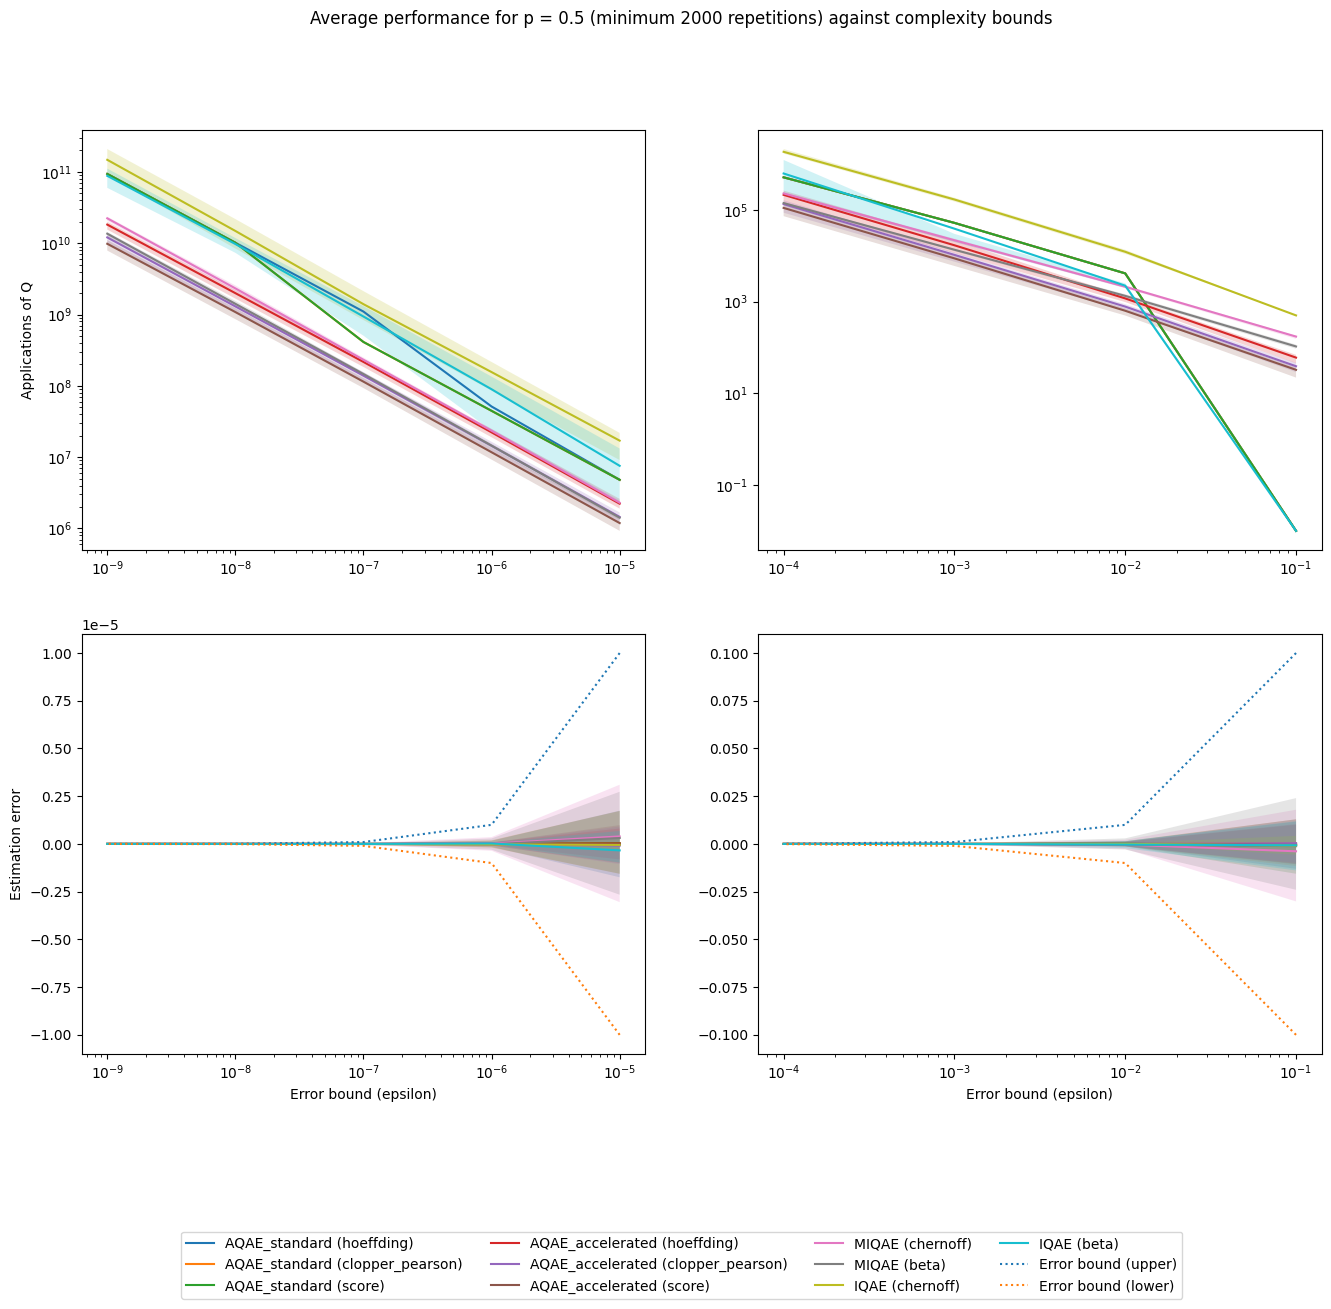

In [13]:
fig, axs = plt.subplots(2,2, figsize=(16, 12))

split = len(epsilon)//2

fig.suptitle('Average performance for p = ' + str(p) + ' (minimum ' + str(max_number_of_reps) + ' repetitions) against complexity bounds', fontsize=12)

for datatype, num in zip(["shots", "estimate"], [0,1]):
    for method in methods:
        for submethod in submethods[method]:
            series = {}
            for info in {"mean", "25%", "75%"}:
                series[info] = np.array([max(data[e][method][submethod][datatype][info],0.01) for e in range(len(epsilon))])
                if datatype=="estimate":
                    series[info] = series[info] - p

            axs[num, 1].plot(epsilon[:split], series["mean"][:split], label = method + " (" + submethod + ")")
            axs[num, 1].fill_between(epsilon[:split], series["25%"][:split], series["75%"][:split], alpha=0.2)
            axs[num, 0].plot(epsilon[split:], series["mean"][split:], label = method + " (" + submethod + ")")
            axs[num, 0].fill_between(epsilon[split:], series["25%"][split:], series["75%"][split:], alpha=0.2)

axs[0, 0].set_ylabel("Applications of Q")
axs[1, 0].set_ylabel("Estimation error")

# error bounds
axs[1, 1].plot(epsilon[:split], epsilon[:split], linestyle = "dotted", label = "Error bound (upper)")
axs[1, 0].plot(epsilon[split:], epsilon[split:], linestyle = "dotted", label = "Error bound (upper)")
axs[1, 1].plot(epsilon[:split], -epsilon[:split], linestyle = "dotted", label = "Error bound (lower)")
axs[1, 0].plot(epsilon[split:], -epsilon[split:], linestyle = "dotted", label = "Error bound (lower)")

for k in range(2):
    axs[0, k].set_yscale('log')
    axs[1,k].set_xlabel("Error bound (epsilon)")
    for l in range(2):
        axs[l,k].set_xscale('log')

labels_handles = {
  label: handle for ax in fig.axes for handle, label in zip(*ax.get_legend_handles_labels())
}
fig.legend(
  labels_handles.values(),
  labels_handles.keys(),
  ncol = 4,
  loc = "lower center",
  bbox_to_anchor = (0, -0.1, 1, 1),
  bbox_transform = plt.gcf().transFigure,
)

plt.savefig(folder_name+"comparison_p="+str(p)+".pdf", format="pdf", bbox_inches="tight")
plt.show()